# Welcome to the Lower-Upper Bound Battle

In [1]:
import numpy as np
import pandas as pd
import glob
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../../util')

import helper as hp

In [2]:
dataset_to_labels = {
    'cifar10': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
    'utkface': ['0-15', '15-25', '25-40', '40-60', '60+'],
    'adience': ['0-2', '4-6', '8-13', '15-20', '25-32', '38-43', '48-53', '60-'] 
}

dataset_to_root_dir = {
    'cifar10': '/NS/twitter-7/work/vnanda/adversarial_disparity/microsoft-smoothing/code/CIFAR10',
    'utkface': '/NS/twitter-7/work/vnanda/adversarial_disparity/microsoft-smoothing/code/utkface',
    'adience': '/NS/twitter-7/work/vnanda/adversarial_disparity/microsoft-smoothing/code/adience'
}

dataset_to_sens_attrs = {
    'cifar10': ['label'],
    'utkface': ['gender', 'race'],
    'adience': ['gender']
}

In [3]:
dataset = 'utkface'
labels = dataset_to_labels[dataset]
root_dir = dataset_to_root_dir[dataset]
sens_attrs = dataset_to_sens_attrs[dataset]
lb_files = glob.glob('{}/*'.format(root_dir))

COLORS = ['blue', 'red', 'green', 'orange', 'magenta', 'yellow', 'black', 'grey']

In [10]:
file

'/NS/twitter-7/work/vnanda/adversarial_disparity/microsoft-smoothing/code/utkface/resnet_output'

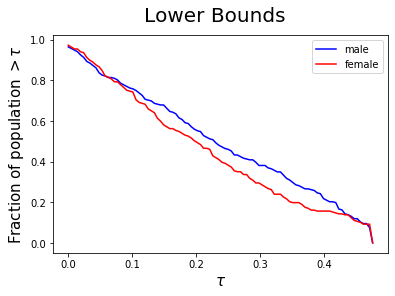

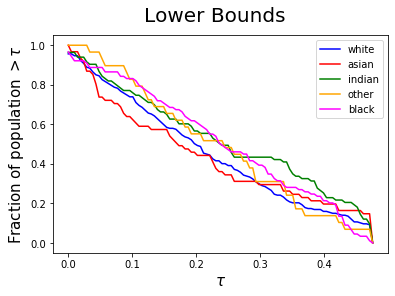

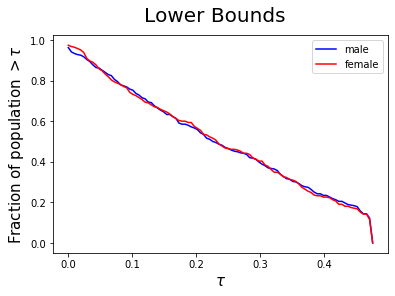

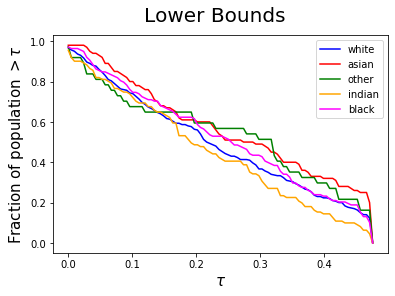

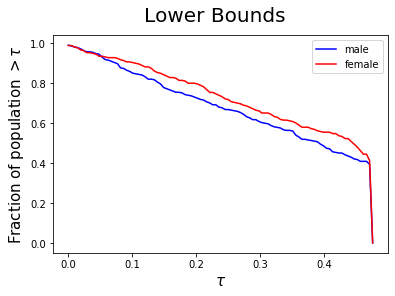

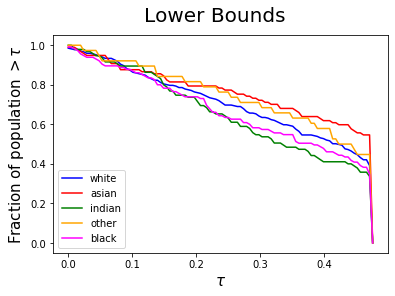

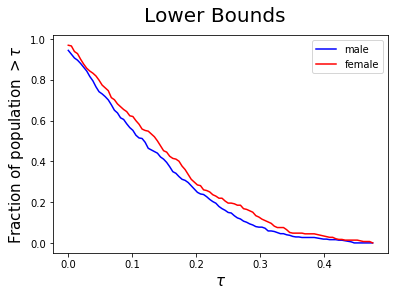

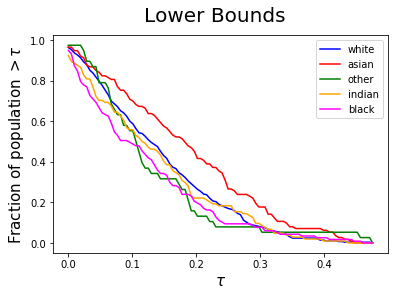

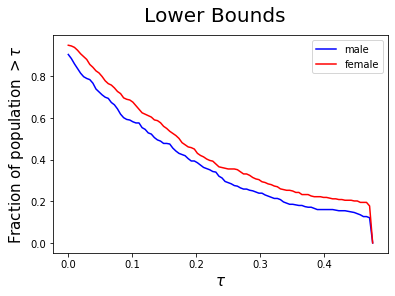

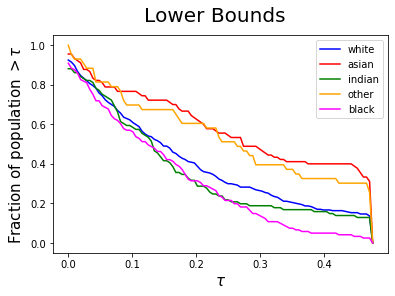

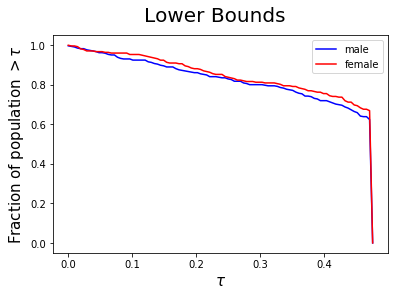

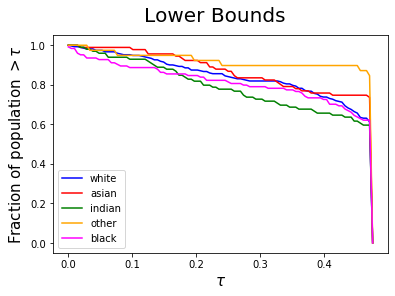

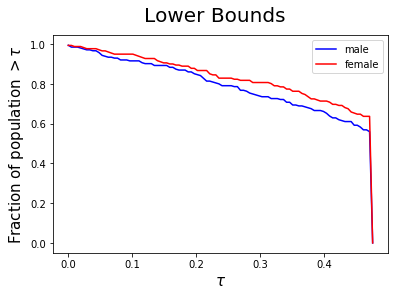

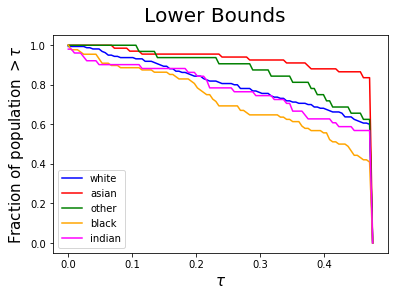

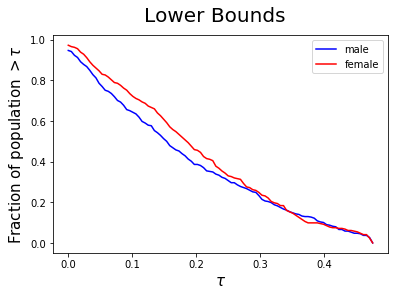

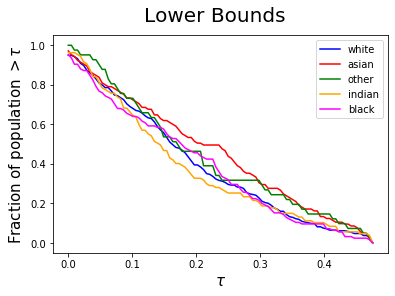

In [6]:
for file in lb_files:
    for sens_attr in sens_attrs:
        op_filename = '{}_{}_lbs'.format(file.split('/')[-1], sens_attr)
        df = pd.read_csv(file, sep='\t')
        try:
            df = df[df['label'] == df['base_prediction']] # take only correct predictions
        except:
            df = df[df['label'] == df['base']] # take only correct predictions
        range_lb = np.linspace(np.min(df['radius']), np.max(df['radius']), 100)

        fig = plt.figure()
        fig.suptitle(r'Lower Bounds', fontsize=20)
        ax = fig.add_subplot(111)
        ax.set_xlabel(r'$\tau$', fontsize=15)
        ax.set_ylabel('Fraction of population '  r'$> \tau$' , fontsize=15)
        for idx, attr in enumerate(df[sens_attr].unique()):
            radius_attr = df['radius'][df[sens_attr] == attr]
            frac_greater_than_tau = \
                np.array([np.sum(radius_attr > t) / len(radius_attr) for t in range_lb])
            ax.plot(range_lb, frac_greater_than_tau, color=COLORS[idx], label=attr)
        plt.legend()
        
        hp.create_dir(dataset)
        
#         plt.savefig('{}/{}.png'.format(dataset, op_filename), bbox_inches='tight')
        plt.show()

In [7]:
df

,idx,label,gender,race,base_prediction,smooth_prediction,radius,time
0,0,2.0,male,white,2.0,1.0,0.476,0:04:54.593289
1,5,0.0,female,white,0.0,-1.0,0.000,0:04:54.501707
2,10,0.0,female,asian,0.0,0.0,0.345,0:04:54.667521
4,20,2.0,male,other,2.0,2.0,0.314,0:04:54.901748
5,25,0.0,male,other,0.0,2.0,0.137,0:04:54.367863
...,...,...,...,...,...,...,...,...
939,4695,2.0,male,white,2.0,1.0,0.208,0:04:54.258757
941,4705,2.0,female,asian,2.0,1.0,0.300,0:04:54.506662
942,4710,2.0,female,white,2.0,1.0,0.206,0:04:54.226315
943,4715,3.0,male,white,3.0,-1.0,0.000,0:04:54.207810


## Upper Bounds

In [11]:
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report

import sys
import time
import operator
import itertools
import numpy as np
import glob
sys.path.insert(0, "../util")

In [13]:
%run ../model.ipynb # defines the model in pytorch; also packs the function to train the model

ERROR:root:File `'pytorch_data_loader.ipynb.py'` not found.
ERROR:root:File `'custom_models.ipynb.py'` not found.
ERROR:root:File `'regularized_loss.ipynb.py'` not found.


In [3]:
## Load other helper functions and classes
%run pytorch_data_loader.ipynb # pytorch data loader class;
%run helper.ipynb # helper functions like
%run ../util/data_loader.ipynb
%run adversarial.ipynb

2.4.0


In [4]:
dataset_name = 'utkface_race'

In [5]:
PHASES = ['train', 'test']
batch_size = 20
learning_rate = 0.0005
device = torch.device('cuda:4')
num_epochs = 50
aggregate_coeff = 5

# downsample_const = 0.9 if 'CIFAR10' in dataset_name else None # How much to shrink class by
downsample_const = None

In [6]:
# Declare the DataLoader object -- conatins the full dataset
ds_obj_complete, datasets_complete, data_loaders_complete = \
    get_data_loder_objects(dataset_name, PHASES, **get_loader_kwargs(batch_size))

In [7]:
# only for CIFAR10
ds_obj_mapping, datasets_mapping, data_loaders_mapping = {}, {}, {}
if downsample_const is not None:
    for i in range(ds_obj_complete.num_classes()):
        ds_obj_mapping[i], datasets_mapping[i], data_loaders_mapping[i] = \
            get_data_loder_objects("CIFAR10_{}".format(ds_obj_complete.classes[i]), 
                                   PHASES, **get_loader_kwargs(batch_size))
        ds_obj_mapping[i].cut_class("train", i, downsample_const)

In [8]:
### ONLY FOR CIFAR10 ###
### ENSURE CLASSES ARE DOWNSAMPLED CORRECTLY ###
# prints nothing if downsampling is done correctly.
# uses downsample_const defined above

if downsample_const is not None:
    # test size of cut class
    for k in range(ds_obj_complete.num_classes()):

        # Checks number of training points and labels match up
        if (len(ds_obj_mapping[k].train_data) != len(ds_obj_mapping[k].train_labels) ):
            print('mismatch in number of points and labels for ds_obj_mapping[{}]'.format(k))

        cut_class_sz = ds_obj_mapping[k].class_size('train', k) 
        uncut_idxs = list(np.arange(10))
        uncut_idxs.remove(k) # k-th index was cut so remove from this list
        not_cut_class_szs = np.asarray([ds_obj_mapping[k].class_size('train', i) for i in uncut_idxs])

        # Ensure no other class is the same size as the downsampled class.
        # if any other class is same size as the downsampled class
        if (not_cut_class_szs != 5000).any(): 
            print('class should have been full size is not')
        if cut_class_sz != round(5000*(1-downsample_const)): # cut class is correctly downsized
            print('class {} was cut but is not correct size'.format(k))

        # prints nothing if everything worked


### Define models

In [9]:
models_to_copies = {} # There will be multiple copies only for CIFAR10, which has many variants of datasets
models_of_interest = get_model_names(dataset_name)[1:]
for model_name in models_of_interest:
    models_to_copies[model_name] = [DNN(model_name=model_name, num_classes=ds_obj_complete.num_classes(), 
                                        learning_rate=learning_rate, aggregate_coeff=aggregate_coeff)]

    if downsample_const is not None:
        for i in range(ds_obj_complete.num_classes()):
            # a separate model for each downsampled instance of CIFAR
            models_to_copies[model_name].append(
                DNN(model_name=model_name, num_classes=ds_obj_complete.num_classes(), 
                    learning_rate=learning_rate, aggregate_coeff=aggregate_coeff))

In [10]:
models_to_copies

{'mlp1_utk': [<__main__.DNN at 0x7f1a92681a90>],
 'resnet': [<__main__.DNN at 0x7f1a96872610>],
 'alexnet': [<__main__.DNN at 0x7f1a92681110>],
 'vgg': [<__main__.DNN at 0x7f1a926a60d0>],
 'squeezenet': [<__main__.DNN at 0x7f1a9255aed0>],
 'densenet': [<__main__.DNN at 0x7f1a92554290>]}

In [ ]:
def image_differences(adv_image_ids, all_adv_images, all_adv_preds, sensitive_attr, ds_obj,
                      attack_name, model_name, root_dir='.'):
    create_dir("{}/{}/".format(root_dir, ds_obj.name))
    create_dir("{}/{}/adversarial_examples".format(root_dir, ds_obj.name))
    create_dir("{}/{}/adversarial_examples/{}".format(root_dir, ds_obj.name, attack_name))
    create_dir("{}/{}/adversarial_examples/{}/{}".format(root_dir, ds_obj.name, attack_name, model_name))
    
    dir_to_save = "{}/{}/adversarial_examples/{}/{}/".format(root_dir, ds_obj.name, attack_name, model_name)
    minority_differences, majority_differences = [], []
    for idx, img_id in enumerate(adv_image_ids):
        processed_img = ds_obj.get_image('test', int(img_id))
        raw_img = inverse_transpose_images(processed_img.numpy(), ds_obj.data_transform)
        adv_img = np.moveaxis(all_adv_images[idx], 0, -1) # channels first, non normalized
        if sensitive_attr[idx] == 1:
            minority_differences.append(np.linalg.norm(raw_img - adv_img))
        else:
            majority_differences.append(np.linalg.norm(raw_img - adv_img))

        if idx < 1:
            concatenated_images = np.concatenate((raw_img, adv_img), axis=1)

            fig = plt.figure()
            fig.suptitle(
                'Left: Original Image (correctly predicted: {})\nRight: Adversarial Image (predicted: {})'.\
                format(ds_obj.classes[ds_obj.get_image_label('test', int(img_id))], ds_obj.classes[int(all_adv_preds[idx])]), 
                fontsize=20)
            ax = fig.add_subplot(111)
            ax.axis('off')
            ax.imshow(concatenated_images, interpolation='bilinear')
            plt.savefig('{}/{}.png'.format(dir_to_save, img_id), bbox_inches='tight')
            plt.show()
            
    return minority_differences, majority_differences

In [ ]:
%run adversarial.ipynb
attack_names = ['DeepFool', 'CarliniWagner'] #, 'Madry']
attack_fractions = [1.0, 1.0] #, 0.05]

# Note that attack_kwargs are only valid for foolbox v3.0.0b1, for v2.4.0 use everything in attack_call_kwargs
### These are for v3.0.0b1
# attack_kwargs = [{'steps': 100}, {'steps': 100, 'random_start': True}, {}]
# # Caution: these epsilon values are only for CIFAR10
# attack_call_kwargs = [{'epsilons': None}, {'epsilons': 3}]

### These are for v2.4.0
attack_kwargs = [{}, {}] #, {'distance': foolbox.distances.Linfinity}]
attack_call_kwargs = [{'steps': 100},{'max_iterations': 100}] #, {'epsilon': 0.3, 'stepsize': 0.01, 'iterations': 100}]

model_to_adversarial_results = {model_name:[] for model_name in get_model_names(dataset_name)}
# [{attack_name: (param_1, param_2 ....), attack_name: (param_1, param_2 ....),}, {}]
for model_name in models_of_interest[3:4]:
    for idx, model in enumerate(models_to_copies[model_name]):
        ds_obj, datasets, data_loaders = (ds_obj_complete, datasets_complete, data_loaders_complete) \
            if idx == 0 else (ds_obj_mapping[idx-1], datasets_mapping[idx-1], data_loaders_mapping[idx-1])

        ### find the middle epoch of training 
        trained_models = glob.glob('../{}/model_weights/{}'.format(ds_obj.name, 
                                                           '{}_epoch_*[0-9]_lr_*.pth'.format(model.model_name)))
        iter_num = 2 if 'mlp' not in model_name.lower() else 3
        iterations = [int(x.split('/')[-1].split('_')[iter_num]) for x in trained_models]
        iterations.sort()
        
        learning_rate = float(trained_models[0].split('/')[-1].split('.pth')[0].split('_')[-1])

        epoch = str(iterations[math.ceil((len(iterations)-1)/2)])
        
        
        filename = '{}_epoch_{}_lr_{}.pth'.format(model.model_name, epoch, learning_rate)
        model.model_ft.load_state_dict(torch.load('../{}/model_weights/{}'.format(ds_obj.name, filename),
                                                 map_location=device))
        print ('Loaded weights from: ../{}/model_weights/{}'.format(ds_obj.name, filename))
        model.model_ft.eval()
        
        mapping = {}
        for attack_name, attack_fraction, attack_kwarg, attack_call_kwarg in zip(attack_names, 
                                                              attack_fractions, 
                                                              attack_kwargs,
                                                              attack_call_kwargs):
            start = time.time()
            attack_class = Attack if '3.0' in foolbox.__version__ else AttackV2
            attack = attack_class(model, ds_obj, device, name=attack_name, 
                            attack_kwargs=attack_kwarg, attack_call_kwargs=attack_call_kwarg)
            all_images_adversarial, all_adv_preds, adv_image_ids, total, created = \
                attack.generate_images(data_loaders, portion='test', fraction=attack_fraction, epoch=epoch)
            
            print ('{}, {} Total: {}, Created: {}'.format(ds_obj.name, attack_name, total, created))
            print ('Time Taken: {}'.format(time.time() - start))
            all_adv_objects = make_pickleable(all_images_adversarial, all_adv_preds, adv_image_ids)
            save_objects(all_adv_objects, model.model_name, adv_image_ids, ds_obj, 
                         attack, epoch=epoch, post_fix='_epsilon_{}'.format(attack_call_kwarg['epsilons'] if \
                             'epsilons' in attack_call_kwarg else None), root_dir='..')
            
            mapping[attack_name] = (all_images_adversarial, all_adv_preds, adv_image_ids)
            with open("../{}/{}_{}_epoch_{}{}_stats.txt".format(ds_obj.name, model_name, 
                                            attack.name, epoch, 
                                            '_epsilon_{}'.format(attack_call_kwarg['epsilons'] if \
                                                 'epsilons' in attack_call_kwarg else None)), 'w') as fp:
                fp.write('{}, {} Total: {}, Created: {}\n'.format(ds_obj.name, attack.name, total, created))
                fp.write('Time Taken: {}\n'.format(time.time() - start))
            
        
        
            ## make the plots and save the cdfs
            
            if downsample_const is not None:
                sensitive_attrs_names = [ds_obj.name.split('_')[-1].lower()]
                sensitive_attrs = [np.array(
                    [1 if ds_obj.classes[ds_obj.test_labels[int(img_id)]] == ds_obj.name.split('_')[-1].lower() \
                    else 0 for img_id in adv_image_ids])]
            elif ds_obj.name.lower() == 'cifar10' or ds_obj.name.lower() == 'cifar100' \
            or ds_obj.name.lower() == 'cifar100super':
                sensitive_attrs, sensitive_attrs_names = [], []
                for i in range(ds_obj.num_classes()):
                    sensitive_attrs_names.append(ds_obj.classes[i])
                    sensitive_attrs.append(np.array(
                        [1 if ds_obj.test_labels[int(img_id)] == i else 0 for img_id in adv_image_ids]))
            else:
                if 'adience' in ds_obj.name.lower():
                    sensitive_attrs = [np.array([ds_obj.get_image_protected_class('test', int(img_id)) \
                                           for img_id in adv_image_ids])]
                else:
                    sens_attr = ds_obj.name.split('_')[-1]
                    sensitive_attrs = [np.array([
                        ds_obj.get_image_protected_class('test', int(img_id), sens_attr) \
                        for img_id in adv_image_ids])]
                sensitive_attrs_names = [ds_obj.get_sens_attr_name()] # this needs to be implemented in ds_obj
            
            for sensitive_attr_name, sensitive_attr in zip(sensitive_attrs_names, sensitive_attrs):
                minority_difference, majority_difference = \
                    image_differences(adv_image_ids, all_images_adversarial, all_adv_preds, sensitive_attr, ds_obj,
                          attack_name, model.model_name, root_dir='..')

                create_dir("plots/{}".format(ds_obj.name))
                create_dir("plots/{}/{}".format(ds_obj.name, model.model_name))
                create_dir("plots/{}/{}/{}".format(ds_obj.name, model.model_name, attack_name))

                dir_to_save = "plots/{}/{}/{}".format(ds_obj.name, model.model_name, attack_name)

                taus = np.linspace(0.0, 2.0, 2000) if 'deepfool' in attack_name.lower() else \
                    np.linspace(0.0, 1.0, 2000) if 'carliniwagner' in attack_name.lower() else \
                    np.linspace(0.0, 0.3, 2000)

                frac_greater_than_tau_majority = \
                    np.array([np.sum(majority_difference > t) / len(majority_difference) for t in taus])
                frac_greater_than_tau_minority = \
                    np.array([np.sum(minority_difference > t) / len(minority_difference) for t in taus])

                cdfs = {'taus': taus,
                        'majority': frac_greater_than_tau_majority,
                        'minority': frac_greater_than_tau_minority}
                cdf_file = 'plots/{}/{}/{}/cdfs_{}_epoch_{}.dat'.format(ds_obj.name, model.model_name, attack_name,
                                                       sensitive_attr_name,epoch)

                with open(cdf_file, "wb") as f:
                    pickle.dump(cdfs, f)

                    
                fig = plt.figure()
                fig.suptitle(r'fraction $d_\theta > \tau$ for {}'.format(ds_obj.name), fontsize=20)
                ax = fig.add_subplot(111)
                ax.plot(taus, frac_greater_than_tau_majority, color='blue', label='Other Classes')
                ax.plot(taus, frac_greater_than_tau_minority, color='red', label='{}'.format(sensitive_attr_name))
                ax.set_xlabel(r'$\tau$', fontsize=15)
                ax.set_ylabel('Fraction', fontsize=15)
                plt.legend()

                plt.savefig('{}/inv_cdf_{}_epoch_{}_from_dat.png'.format(dir_to_save, sensitive_attr_name, epoch), bbox_inches='tight')
                plt.show()
                plt.close()
                
        model_to_adversarial_results[model_name].append(mapping)
